# Look at CSV

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('point_survey_v1.csv')

In [3]:
df.shape

(1585, 59)

In [4]:
df.columns

Index(['district', 'segment_id', 'point_id', 'point_code', 'su_id', 'su_date',
       'su_date_year', 'su_date_month', 'su_date_day', 'start_time',
       'start_time_hour', 'start_time_minute', 'dist_point', 'dist_m',
       'imp_type', 'imp_type_qualifier', 'imp_list', 'imp_list_qualifier',
       'wp_gps', 'coord_obs', 'coord_obs_srs', 'coord_obs_x', 'coord_obs_y',
       'point_obs', 'not_obs', 'not_obs_qualifier', 'point_loc', 'lc_cat1',
       'lc_group1', 'lc_code1', 'lc_code1_qualifier', 'lc_pct1', 'lc_sea1',
       'lc_sea1_qualifier', 'lc_cat2', 'lc_group2', 'lc_code2',
       'lc_code2_qualifier', 'lc_pct2', 'lc_sea2', 'lc_sea2_qualifier',
       'lc_cat3', 'lc_group3', 'lc_code3', 'lc_code3_qualifier', 'lc_pct3',
       'lc_sea3', 'lc_sea3_qualifier', 'pct_check', 'harvest',
       'harvest_qualifier', 'd_harv', 'irrig', 'lc_remark', 'photo', 'remarks',
       'entry_loc', 'entry_loc_qualifier', 'end_time'],
      dtype='object')

Assigning IDs to each row for reference.

In [21]:
id = range(df.shape[0])
id = [str(i).zfill(5) for i in id]
df['unique_id'] = id

# Strategy
Since we are only given a set of coordinates for reference, and the distance from that point to the relevant observation, I defined a function that creates a bounding box of sorts around that coordinate that spans a certain amount of distance. My idea for now is to create bounding boxes of width and height of 500m *2 for observations that can be found within 500m of the reference point. Average farm area in Nepal is 40468.6 m*m, for observations further than 500m from the reference point we'll create a box wit dimensions of (Distance given + 250m) *2.

In [11]:
def bb_from_coords(lat,long,dist,inverse=True):
    #Lat long in degrees
    #Distance is in Meters
    if inverse:
        lat, long = long, lat
    
    from math import pi, acos, asin, cos, sin
    R = 6371
    def deg2rad(x):
        return x * pi / 180

    def rad2deg(x):
        return x / (pi / 180)
    
    lat, long = deg2rad(lat), deg2rad(long)
    distance_km = dist/1000
    r = distance_km/R 
    
    latmin = lat - r 
    latmax = lat + r
    Δlong = asin(sin(r)/cos(lat))
    longmin = long - Δlong
    longmax = long + Δlong
    
    latmin, longmin, latmax, longmax = rad2deg(latmin), rad2deg(longmin), rad2deg(latmax), rad2deg(longmax)
    
    if inverse:
        return [longmin, latmin, longmax, latmax]
    
    return [latmin, longmin, latmax, longmax]

# Download Images

In [24]:
#Start Google Earth Engine
import ee
ee.Initialize()

In [ ]:
#Load collection once, and just loop take the relevant regions later
dataset = ee.ImageCollection('COPERNICUS/S2')\
    .filterDate('2016-10-01', '2016-11-30')\
    .select(['B4', 'B3', 'B2'])\

for n, row in df.iterrows():
  x, y, dist = row['coord_obs_x'], row['coord_obs_y'], row['dist_m']
  #Let's ignore the date from now and just take observations between Oct and Nov
  date = row['su_date']
  if dist > 500:
    dist+=250
  else:
    dist = 500
  geom = ee.Geometry.Rectangle(bb_from_coords(x,y,dist,True))
  reduction = dataset.filterBounds(geom).mosaic()
  stats = reduction.reduceRegion(reducer=ee.Reducer.minMax(),geometry=geom,scale=1,bestEffort=True)
  statDict = stats.getInfo()
  prettyImg = reduction.visualize(bands=['B4', 'B3', 'B2'],
                       min=[statDict['B4_min'],statDict['B3_min'],statDict['B2_min']],
                       max=[statDict['B4_max'],statDict['B3_max'],statDict['B2_max']],
                       gamma=1)
  #NEXT LINE IS OPTIONAL, RUN IT TO GET A URL THAT YOU CAN VIEW YOUR IMG IN
#   prettyImg.getThumbUrl({'region':geom.toGeoJSON()})
  fileName =  str(row['unique_id'])
  task = ee.batch.Export.image.toDrive(prettyImg, folder='nepal', region=geom['coordinates'][0], scale=1, description=fileName)
  task.start()






# Visualise Image in Python

In [132]:
import rasterio
from rasterio.plot import show

In [134]:
src = rasterio.open('img1.tif')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


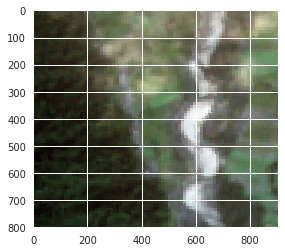

In [145]:
import numpy as np
import matplotlib.pyplot as plt
# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Convert to numpy arrays
red = src.read(3)
green = src.read(2)
blue= src.read(1)


# Normalize band DN
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)


# Stack bands
nrg = np.dstack((redn,greenn,bluen))

# View the color composite
plt.imshow(nrg)